In [1]:
from ultralytics import YOLO
import torch
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2
import matplotlib.pyplot as plt

from model_cnn_transformer import OCRModel
from dataset_polygon import char2idx, idx2char

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
VOCAB_SIZE = len(char2idx)
OCR_MODEL_PATH = "./models/best_ocr_model.pth"
YOLO_MODEL_PATH = "./models/best.pt"

In [2]:
from torchvision import transforms


def preprocess_ocr_image(pil_img):
    transform = transforms.Compose(
        [
            transforms.Resize((32, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    return transform(pil_img).unsqueeze(0)


def decode_sequence(indices):
    chars = []
    SOS_TOKEN = next((token for token in char2idx.keys() if "SOS" in token), None)
    for idx in indices:
        ch = idx2char.get(idx, "")
        if ch == "<EOS>":
            break
        if ch not in ("<PAD>", SOS_TOKEN):
            chars.append(ch)
    return "".join(chars)

In [3]:
# Load models
yolo_model = YOLO(YOLO_MODEL_PATH)
ocr_model = OCRModel(vocab_size=VOCAB_SIZE).to(DEVICE)
ocr_model.load_state_dict(torch.load(OCR_MODEL_PATH, map_location=DEVICE))
ocr_model.eval()

FONT_PATH = "Roboto-Regular.ttf"


def draw_vietnamese_boxes_text(img_pil, bboxes, texts, font_size=18):
    draw = ImageDraw.Draw(img_pil)
    font = ImageFont.truetype(FONT_PATH, font_size)
    for (x1, y1, x2, y2), txt in zip(bboxes, texts):
        draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=2)
        draw.text((x1, max(y1 - 22, 0)), txt, fill=(255, 0, 0), font=font)
    return img_pil


def yolo_ocr_pipeline(image_path, show_image=True):
    # 1. Detection
    results = yolo_model(image_path)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    confs = results[0].boxes.conf.cpu().numpy()  # confidence scores
    filtered = [(box, conf) for box, conf in zip(boxes, confs) if conf > 0.5]
    boxes = [box for box, conf in filtered]

    # 2. Crop từng bbox và nhận diện text
    img_pil = Image.open(image_path).convert("RGB")
    texts = []
    bboxes = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        crop = img_pil.crop((x1, y1, x2, y2))
        image_tensor = preprocess_ocr_image(crop).to(DEVICE)
        with torch.no_grad():
            memory = ocr_model.encoder(image_tensor)
            SOS_TOKEN = next(
                (token for token in char2idx.keys() if "SOS" in token), None
            )
            MAX_LEN = 36
            ys = torch.tensor([[char2idx[SOS_TOKEN]]], device=DEVICE)
            for _ in range(MAX_LEN):
                out = ocr_model.decoder(
                    ys,
                    memory,
                    tgt_mask=ocr_model.generate_square_subsequent_mask(ys.size(1)).to(
                        DEVICE
                    ),
                )
                prob = out[:, -1, :]
                _, next_word = torch.max(prob, dim=1)
                ys = torch.cat([ys, next_word.unsqueeze(1)], dim=1)
                if next_word.item() == char2idx["<EOS>"]:
                    break
            pred_text = decode_sequence(ys.squeeze(0).tolist())
            texts.append(pred_text)
            bboxes.append((x1, y1, x2, y2))

    # 3. Hiển thị kết quả
    if show_image:
        img_vn = draw_vietnamese_boxes_text(img_pil.copy(), bboxes, texts, font_size=15)
        plt.figure(figsize=(16, 12))
        plt.imshow(img_vn)
        plt.axis("off")
        plt.show()

    return list(zip(bboxes, texts))

c:\Users\Nguyen\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nguyen\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



image 1/1 c:\Users\Nguyen\Desktop\compare_ocr_benchmark\CNN_TR_OCR_Resnet\hinh-anh-30-4-25-1.jpg: 384x640 11 texts, 112.3ms
Speed: 3.1ms preprocess, 112.3ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)


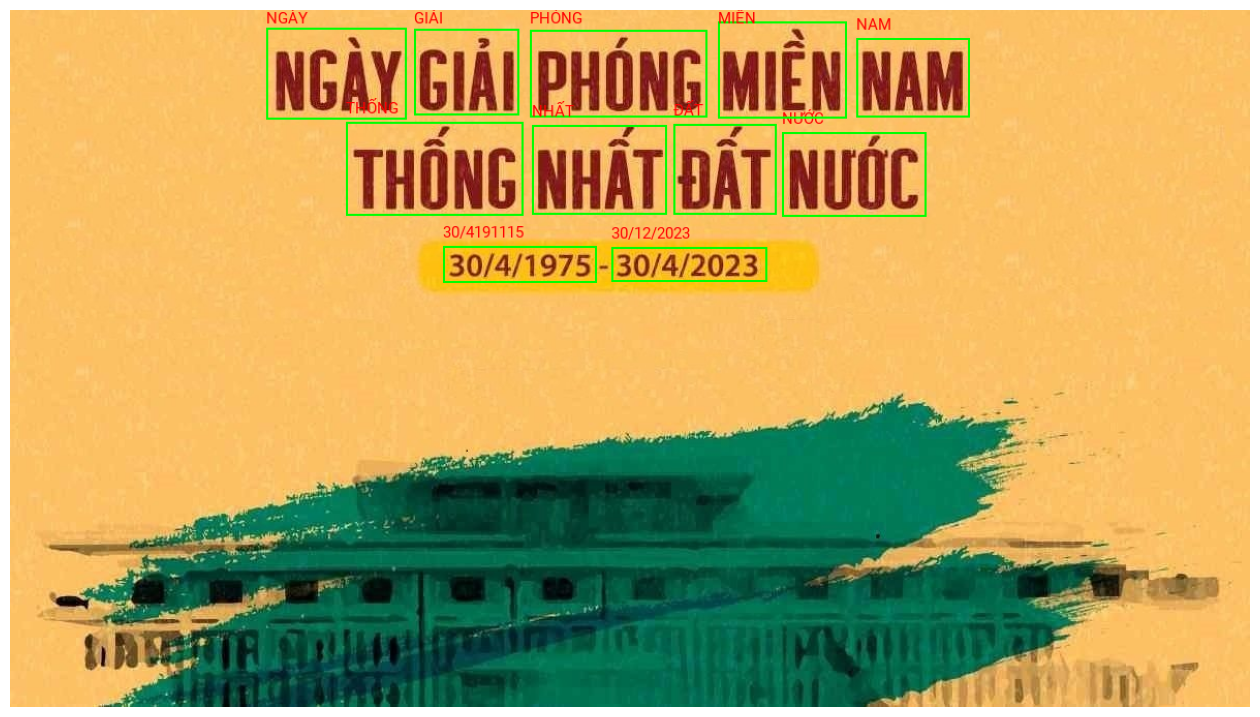

Bounding Box: (325, 109, 496, 199), Text: THỐNG
Bounding Box: (503, 20, 674, 104), Text: PHÓNG
Bounding Box: (248, 18, 383, 106), Text: NGÀY
Bounding Box: (642, 111, 741, 198), Text: ĐẤT
Bounding Box: (819, 28, 928, 104), Text: NAM
Bounding Box: (505, 112, 635, 198), Text: NHẤT
Bounding Box: (747, 119, 886, 200), Text: NƯỚC
Bounding Box: (685, 12, 809, 105), Text: MIÊN
Bounding Box: (391, 19, 492, 102), Text: GIẢI
Bounding Box: (582, 230, 732, 263), Text: 30/12/2023
Bounding Box: (419, 229, 567, 264), Text: 30/4191115


In [4]:
# result = yolo_ocr_pipeline("vietnamese/unseen_test_images/im1510.jpg")
result = yolo_ocr_pipeline("./hinh-anh-30-4-25-1.jpg")
for bbox, text in result:
    print(f"Bounding Box: {bbox}, Text: {text}")

In [5]:
def group_text_lines(results, y_threshold=80, x_threshold=150):
    """
    Nhóm bbox thành dòng, ưu tiên trái-phải nếu 2 bbox gần nhau theo y.
    """
    # Tính y_center, x_left
    bboxes_with_text = []
    for bbox, text in results:
        x1, y1, x2, y2 = bbox
        y_center = (y1 + y2) / 2
        x_left = min(x1, x2)
        x_right = max(x1, x2)
        height = abs(y2 - y1)
        width = abs(x2 - x1)
        bboxes_with_text.append(
            {
                "bbox": bbox,
                "text": text,
                "y_center": y_center,
                "x_left": x_left,
                "x_right": x_right,
                "height": height,
                "width": width,
            }
        )

    # Sắp xếp ban đầu theo y_center (trên xuống dưới), x_left (trái-phải)
    bboxes_with_text.sort(key=lambda x: (x["y_center"], x["x_left"]))

    lines = []
    for item in bboxes_with_text:
        added = False
        for line in lines:
            # So sánh y với từng box trong dòng, chỉ cần gần 1 từ là OK
            if any(abs(item["y_center"] - i["y_center"]) < y_threshold for i in line):
                line.append(item)
                added = True
                break
        if not added:
            lines.append([item])

    # Sau khi group dòng, sort mỗi dòng theo x_left (trái-phải)
    for line in lines:
        line.sort(key=lambda x: x["x_left"])
    return lines


def print_ocr_lines_grouped(results, y_threshold=80):
    grouped_lines = group_text_lines(results, y_threshold=y_threshold)
    for line in grouped_lines:
        text_line = " ".join([item["text"] for item in line])
        print(text_line)


image 1/1 c:\Users\Nguyen\Desktop\compare_ocr_benchmark\CNN_TR_OCR_Resnet\hinh-anh-30-4-25-1.jpg: 384x640 11 texts, 50.5ms
Speed: 1.5ms preprocess, 50.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


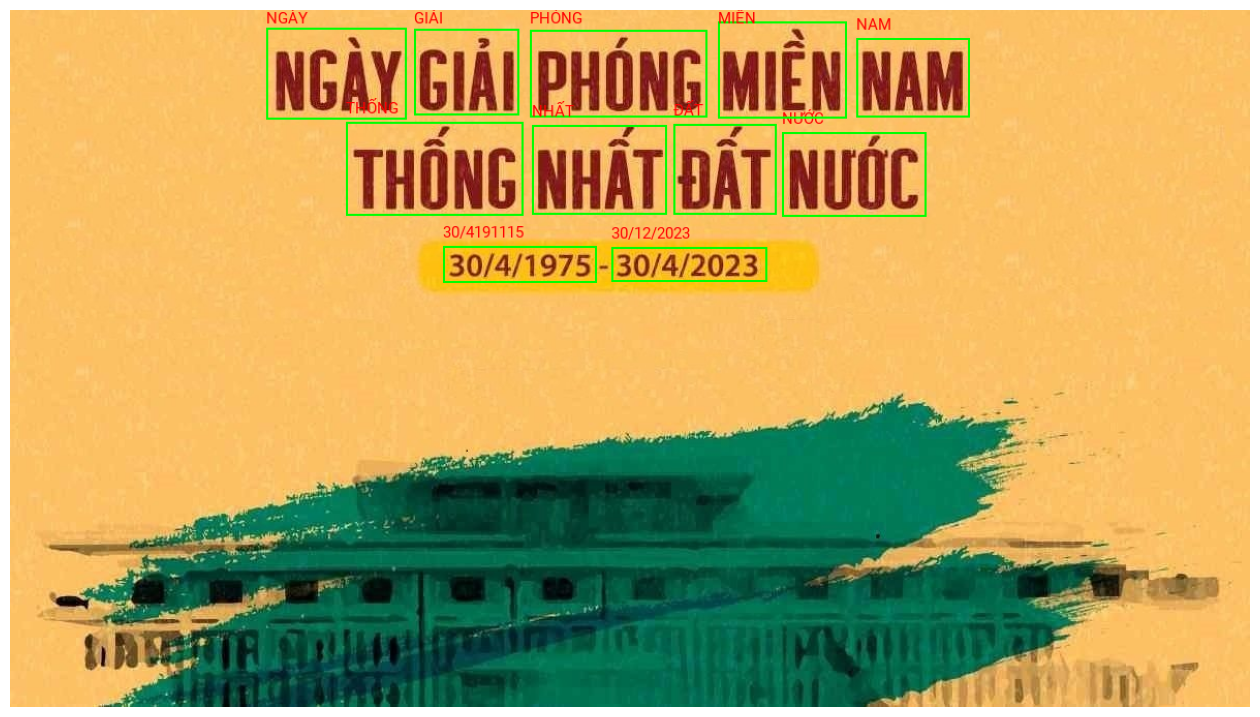


--- Kết quả OCR dạng văn bản thực tế ---
NGÀY GIẢI PHÓNG MIÊN NAM
THỐNG NHẤT ĐẤT NƯỚC
30/4191115 30/12/2023


In [6]:
# Sử dụng:
result = yolo_ocr_pipeline("./hinh-anh-30-4-25-1.jpg")
print("\n--- Kết quả OCR dạng văn bản thực tế ---")
print_ocr_lines_grouped(result, y_threshold=70)